data source: https://aqicn.org/data-platform/register/<br>
prasertcbs: https://www.youtube.com/watch?v=COtinIQk12w&t=53s

Lightgbm พื้นฐาน model มาจาก Decision tree

In [172]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# format pprint import pprint
import shap

'''Model'''
import lightgbm as lgb

In [173]:
path = "bangkok-air-quality.csv"
df = pd.read_csv(path, parse_dates=["date"], na_values=[" "], skipinitialspace= True) #whitespace
df

,date,pm25,pm10,o3,no2,so2,co
0,2023-08-01,59.0,34.0,7.0,4.0,14.0,NaN
1,2023-08-02,67.0,29.0,10.0,NaN,NaN,NaN
2,2023-08-03,72.0,33.0,14.0,8.0,3.0,NaN
3,2023-08-04,69.0,29.0,12.0,7.0,4.0,NaN
4,2023-08-05,64.0,28.0,9.0,7.0,13.0,NaN
...,...,...,...,...,...,...,...
3515,2015-03-15,NaN,NaN,23.0,13.0,3.0,9.0
3516,2014-11-30,NaN,NaN,40.0,36.0,4.0,11.0
3517,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
3518,2014-01-26,NaN,NaN,54.0,53.0,6.0,18.0


In [174]:
df = df.loc[:,:"pm25"]
df

,date,pm25
0,2023-08-01,59.0
1,2023-08-02,67.0
2,2023-08-03,72.0
3,2023-08-04,69.0
4,2023-08-05,64.0
...,...,...
3515,2015-03-15,NaN
3516,2014-11-30,NaN
3517,2013-12-31,NaN
3518,2014-01-26,NaN


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3520 entries, 0 to 3519
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3520 non-null   datetime64[ns]
 1   pm25    2576 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 55.1 KB


In [176]:
df = df.sort_values("date")
df = df.reset_index(drop=True)
df

,date,pm25
0,2013-12-31,NaN
1,2014-01-01,NaN
2,2014-01-02,NaN
3,2014-01-03,NaN
4,2014-01-04,NaN
...,...,...
3515,2023-08-23,60.0
3516,2023-08-24,55.0
3517,2023-08-25,56.0
3518,2023-08-26,61.0


In [177]:
# df.iloc[938]

### Data Preprocess -> Clear NaN

In [178]:
colPm25 = "pm25"

In [179]:
df = df.dropna(subset=[colPm25])
df

,date,pm25
938,2016-07-30,61.0
939,2016-07-31,68.0
940,2016-08-01,60.0
941,2016-08-02,68.0
942,2016-08-03,70.0
...,...,...
3515,2023-08-23,60.0
3516,2023-08-24,55.0
3517,2023-08-25,56.0
3518,2023-08-26,61.0


In [180]:
df = df.reset_index(drop=True) #drop index เก่าที่ไม่มีข้อมูลทิ้งไป
df

,date,pm25
0,2016-07-30,61.0
1,2016-07-31,68.0
2,2016-08-01,60.0
3,2016-08-02,68.0
4,2016-08-03,70.0
...,...,...
2571,2023-08-23,60.0
2572,2023-08-24,55.0
2573,2023-08-25,56.0
2574,2023-08-26,61.0


### Create Col YY, MM ,DD, DD Column

In [181]:
def date_parts(dataFrame, date_col="date"):
    dataFrame["year"] = dataFrame["date"].dt.year
    dataFrame["month"] = dataFrame["date"].dt.month
    dataFrame["day"] = dataFrame["date"].dt.day
    dataFrame["day_name"] = dataFrame["date"].dt.day_name().astype("category")

In [182]:
date_parts(df)
df

,date,pm25,year,month,day,day_name
0,2016-07-30,61.0,2016,7,30,Saturday
1,2016-07-31,68.0,2016,7,31,Sunday
2,2016-08-01,60.0,2016,8,1,Monday
3,2016-08-02,68.0,2016,8,2,Tuesday
4,2016-08-03,70.0,2016,8,3,Wednesday
...,...,...,...,...,...,...
2571,2023-08-23,60.0,2023,8,23,Wednesday
2572,2023-08-24,55.0,2023,8,24,Thursday
2573,2023-08-25,56.0,2023,8,25,Friday
2574,2023-08-26,61.0,2023,8,26,Saturday


## Start

In [183]:
df = df.set_index("date")
df

,pm25,year,month,day,day_name
date,,,,,
2016-07-30,61.0,2016,7,30,Saturday
2016-07-31,68.0,2016,7,31,Sunday
2016-08-01,60.0,2016,8,1,Monday
2016-08-02,68.0,2016,8,2,Tuesday
2016-08-03,70.0,2016,8,3,Wednesday
...,...,...,...,...,...
2023-08-23,60.0,2023,8,23,Wednesday
2023-08-24,55.0,2023,8,24,Thursday
2023-08-25,56.0,2023,8,25,Friday


### Visualize data

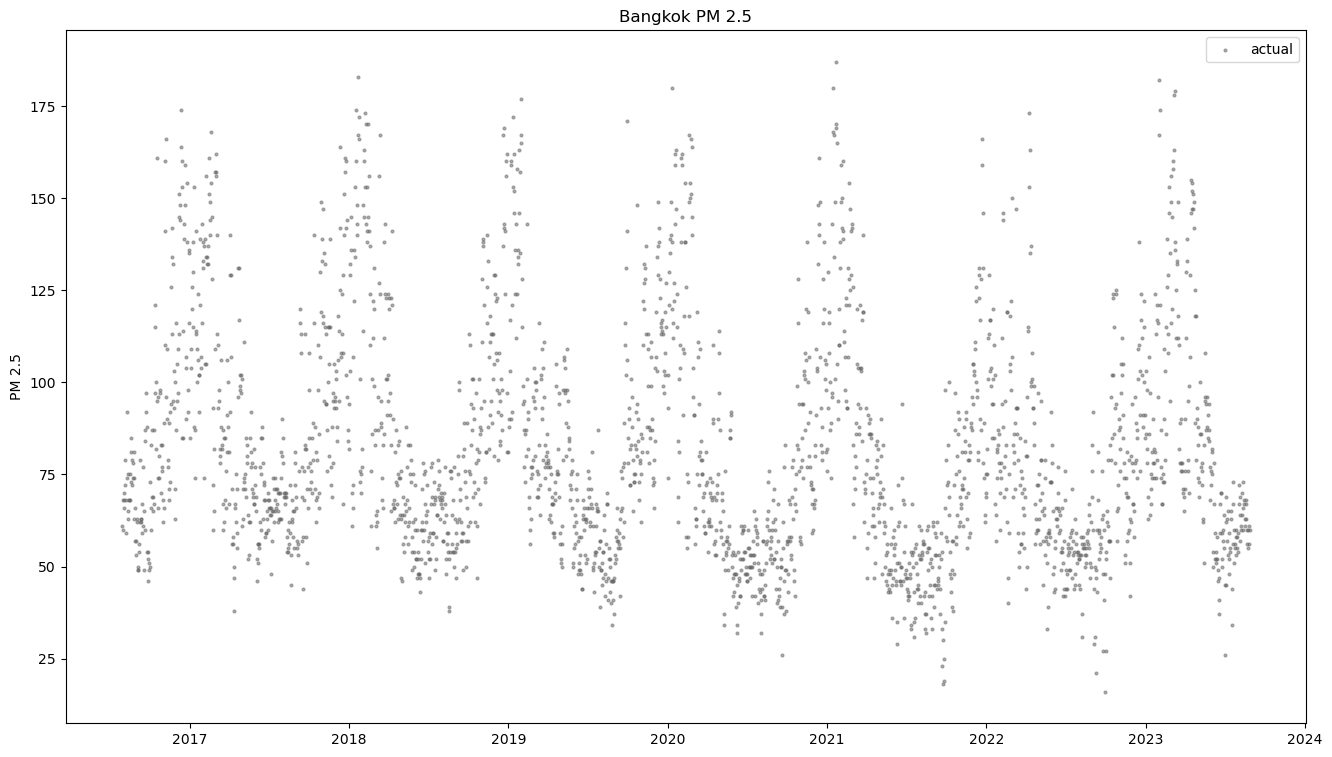

In [184]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[colPm25], alpha=.5, s=4, label='actual', color='.4')
plt.ylabel('PM 2.5')
plt.title('Bangkok PM 2.5')
plt.legend();

## Lightgbm regressor Model
 lightGBM doc: https://lightgbm.readthedocs.io/en/latest/
 <br>
 LGBMRegressor: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

In [185]:
feature_cols = ["year", "month", "day", "day_name"]
X = df[feature_cols] #select feature
y = df[colPm25] # class target

In [186]:
#เนื่องจากเป็น Time series ไม่สามารถใช้ train_test_split ได้เพราะเป็นการสุ่มข้อมูล การทำนาย Time series จำเป็นต้อง sort ตาม col date
split_at = int(len(df.index)*0.70) 
split_at

1803

In [187]:
X_train, X_test, y_train, y_test = X[:split_at], X[split_at:], y[:split_at], y[split_at:]

In [188]:
params = {"learning_rate":0.5, "max_depth":10, "num_leaves":100}
reg =lgb.LGBMRegressor(**params)
# reg = lgb.LGBMRegressor()
reg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.5,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 100,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [189]:
fit_params = {"early_stopping_rounds":1000,
             "eval_set":[(X_test, y_test)],
             "verbose":10}
reg.fit(X_train,y_train, **fit_params)

[10]	valid_0's l2: 788.003
[20]	valid_0's l2: 854.505
[30]	valid_0's l2: 885.689
[40]	valid_0's l2: 891.164
[50]	valid_0's l2: 905.172
[60]	valid_0's l2: 926.032
[70]	valid_0's l2: 932.778
[80]	valid_0's l2: 939.603
[90]	valid_0's l2: 949.305
[100]	valid_0's l2: 959.882


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMRegressor(learning_rate=0.5, max_depth=10, num_leaves=100)

In [190]:
# reg.__dict__

In [191]:
reg.score(X_train,y_train) #Train Rsquare Error

0.4850196147696698

In [192]:
reg.score(X_test,y_test) #test Rsquare Error

0.22388825103921173

In [193]:
reg.predict(X_test[:5])

array([68.86313319, 68.86313319, 68.86313319, 68.86313319, 68.86313319])

### Visualize forecast

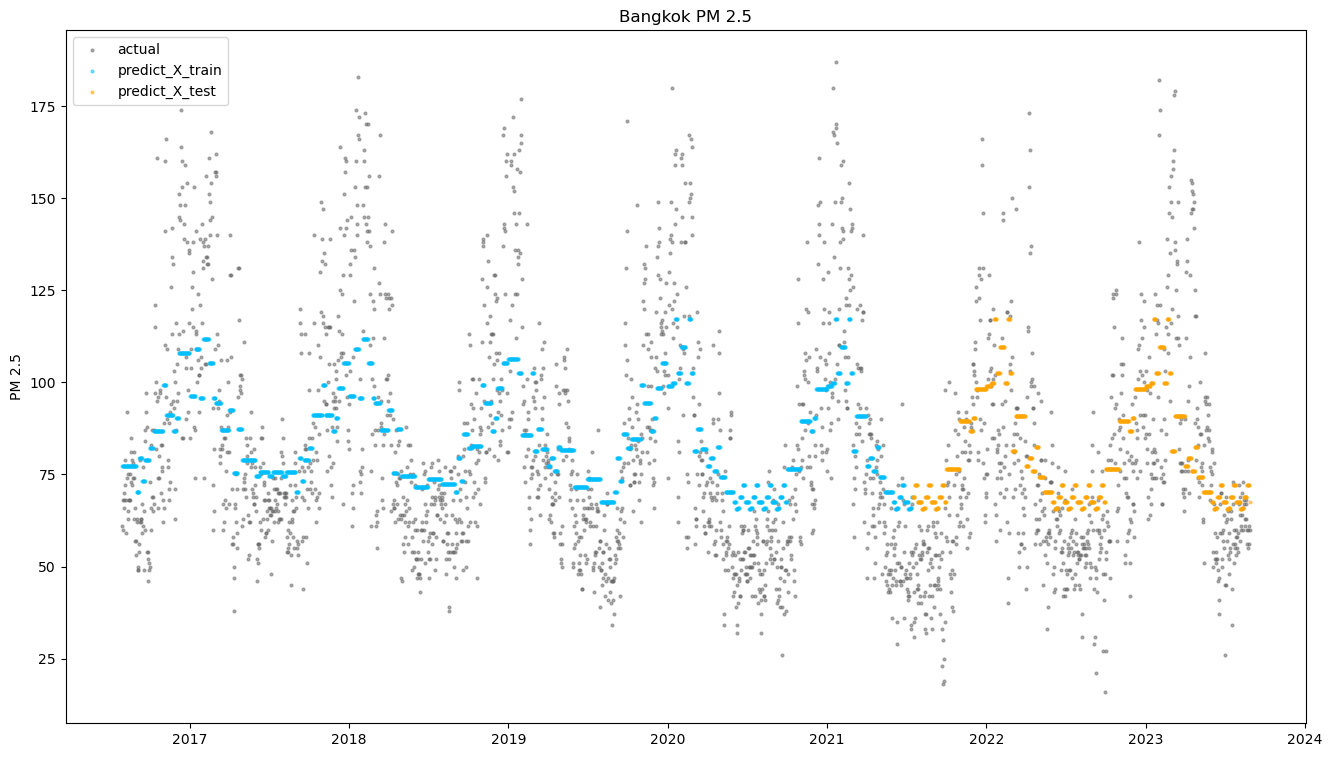

In [194]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[colPm25], alpha=.5, s=4, label='actual', color='.4')
plt.scatter(X_train.index, reg.predict(X_train), alpha=.5, s=4, label='predict_X_train', color='deepskyblue')
plt.scatter(X_test.index, reg.predict(X_test), alpha=.5, s=4, label='predict_X_test', color='orange')
plt.ylabel('PM 2.5')
plt.title('Bangkok PM 2.5')
plt.legend();

### SHAP สำหรับดู Feature ที่ส่งผลต่อค่า PM2.5
document: https://github.com/slundberg/shap

In [195]:
shap.initjs()

In [196]:
explain = shap.TreeExplainer(reg)
shap_values = explain.shap_values(X) #ดู Features ที่ส่งผลต่อค่า PM2.5

In [197]:
explain.__dict__

{'model': <shap.explainers._tree.TreeEnsemble at 0x23477548340>,
 'output_names': None,
 'feature_names': None,
 'masker': None,
 'link': CPUDispatcher(<function identity at 0x000002346FF871F0>),
 'linearize_link': True,
 'data': None,
 'data_missing': None,
 'feature_perturbation': 'tree_path_dependent',
 'expected_value': 84.67221294784804,
 'model_output': 'raw',
 'approximate': False}

In [198]:
#shap_values.shape
shap_values[:3]
# +ส่งผลให้ PM สูง, -ส่งผลให้ PM ต่ำ

array([[  3.69174777, -10.77336031,  -0.22419075,   0.        ],
       [  3.69174777, -10.77336031,  -0.22419075,   0.        ],
       [  4.8358255 , -11.69928025,  -0.44234854,   0.        ]])

In [199]:
X[:5]

,year,month,day,day_name
date,,,,
2016-07-30,2016,7,30,Saturday
2016-07-31,2016,7,31,Sunday
2016-08-01,2016,8,1,Monday
2016-08-02,2016,8,2,Tuesday
2016-08-03,2016,8,3,Wednesday


In [200]:
#shap to dataFrame
df_Shap = pd.DataFrame(shap_values, columns= feature_cols)
df_Shap #ลองดูความหมายเทียบกับ X[:5]

,year,month,day,day_name
0,3.691748,-10.773360,-0.224191,0.0
1,3.691748,-10.773360,-0.224191,0.0
2,4.835826,-11.699280,-0.442349,0.0
3,4.835826,-11.699280,-0.442349,0.0
4,4.835826,-11.699280,-0.442349,0.0
...,...,...,...,...
2571,-1.736678,-13.630667,2.697906,0.0
2572,-1.815856,-12.677818,1.824234,0.0
2573,-1.815856,-12.677818,1.824234,0.0
2574,-1.815856,-12.677818,1.824234,0.0


In [201]:
np.abs(df_Shap).mean().sort_values(ascending=False)
#month เป็นปัจจัยที่ส่งผลต่อค่า PM มากที่สุด

month       10.587617
year         2.432145
day          1.301256
day_name     0.000000
dtype: float64

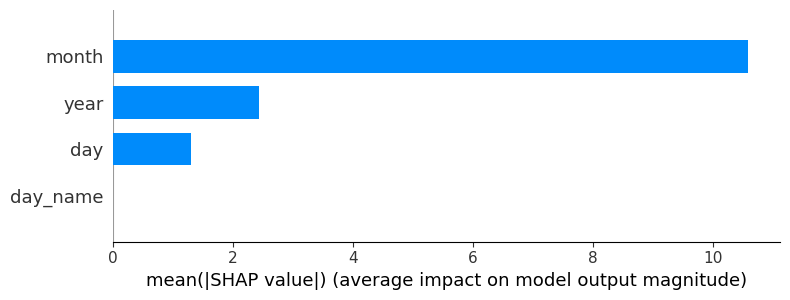

In [202]:
shap.summary_plot(df_Shap, X, plot_type="bar")

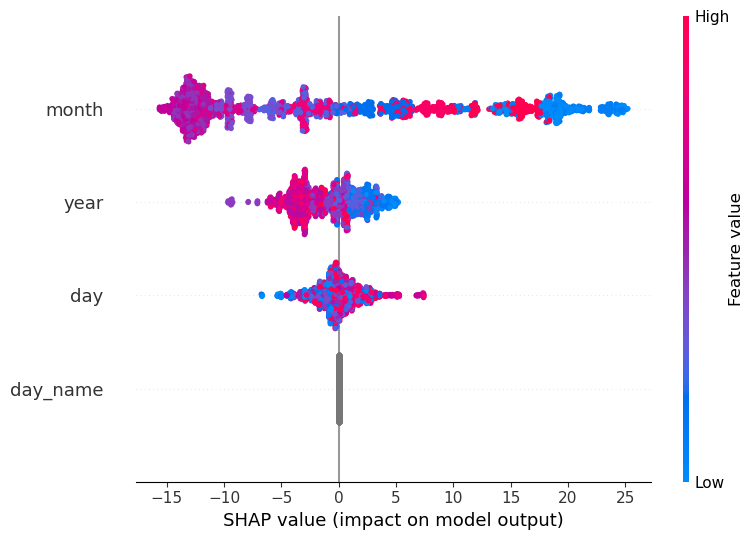

In [203]:
shap.summary_plot(shap_values, X, plot_size=1)
#Low คือริ่มจากต้นๆ เช่นถ้า month คือเดือนมกราคม,high เป็นธันวาคม